# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [72]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
# Import API key
from api_keys import weather_api_key
from datetime import datetime

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [73]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))

618


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [74]:
city=[]
lat=[]
lng=[]
humidity=[]
clouds=[]
windspeed=[]
country=[]
date=[]
max_temp=[]
weather_dict ={"City": city,"Latitude":lat,"Longitude":lng,"Max Temperature (Celsius)": max_temp,"Humidity (%)":humidity,"Cloudiness (%)":clouds,"Wind Speed (mph)":windspeed,"Country": country,"Date":date}
j=1
print("Beginning Data Retrieval\n-----------------------------")
#Build query url
for i in range(len(cities)):
    url=f'https://api.openweathermap.org/data/2.5/weather?q={cities[i]}&appid={weather_api_key}'
    #get weather data
    weather_response = requests.get(url)
    weather_json=weather_response.json()
    try:
        city.append(weather_json['name'])
        lat.append(weather_json['coord']['lat'])
        lng.append(weather_json['coord']['lon'])
        max_temp.append(round(weather_json['main']['temp_max']-273.15,2))
        humidity.append(weather_json['main']['humidity'])
        clouds.append(weather_json['clouds']['all'])
        windspeed.append(weather_json['wind']['speed'])
        country.append(weather_json['sys']['country'])
        date.append(time.strftime('%D %H:%M', time.localtime(int(weather_json['dt']))))
        if i == j*50:
            j+=1
        print(f"Processing Record {i+1} of set {j} | {city[-1]}")
    except KeyError:
        if i == j*50:
            j+=1
        print("City not found. Skipping...")


Beginning Data Retrieval
-----------------------------
Processing Record 1 of set 1 | Namatanai
Processing Record 2 of set 1 | Bredasdorp
Processing Record 3 of set 1 | Chara
Processing Record 4 of set 1 | Puerto Ayora
Processing Record 5 of set 1 | New Norfolk
Processing Record 6 of set 1 | Shiyan
Processing Record 7 of set 1 | Punta Arenas
Processing Record 8 of set 1 | Tura
Processing Record 9 of set 1 | Mataura
Processing Record 10 of set 1 | Zdvinsk
Processing Record 11 of set 1 | Cape Town
Processing Record 12 of set 1 | Albany
Processing Record 13 of set 1 | Inuvik
Processing Record 14 of set 1 | Beringovskiy
Processing Record 15 of set 1 | Bengkulu
Processing Record 16 of set 1 | Kamenka
Processing Record 17 of set 1 | Jamestown
Processing Record 18 of set 1 | Qaanaaq
Processing Record 19 of set 1 | Terme
Processing Record 20 of set 1 | Naze
Processing Record 21 of set 1 | Mawlamyine
Processing Record 22 of set 1 | Nanortalik
Processing Record 23 of set 1 | Aktash
City not foun

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [75]:
raw_weather_df=pd.DataFrame(weather_dict)
raw_weather_df.to_csv("output_data/raw_city_data.csv",)
raw_weather_df

,City,Latitude,Longitude,Max Temperature (Celsius),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,Namatanai,-3.6667,152.4333,27.31,81,99,3.14,PG,02/04/21 02:20
1,Bredasdorp,-34.5322,20.0403,22.00,68,13,2.06,ZA,02/04/21 02:16
2,Chara,56.9064,118.2631,-25.50,78,100,0.25,RU,02/04/21 02:20
3,Puerto Ayora,-0.7393,-90.3518,24.44,94,98,3.53,EC,02/04/21 02:20
4,New Norfolk,-42.7826,147.0587,26.67,48,93,1.34,AU,02/04/21 02:20
...,...,...,...,...,...,...,...,...,...
559,Arman',59.7000,150.1667,-18.22,81,61,9.06,RU,02/04/21 02:23
560,San Martín,-33.0810,-68.4681,18.00,63,0,1.29,AR,02/04/21 02:23
561,Sechura,-5.5569,-80.8222,23.23,69,97,3.46,PE,02/04/21 02:23
562,Panabá,21.2833,-88.2667,15.41,89,0,2.32,MX,02/04/21 02:23


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [76]:
#  Get the indices of cities that have humidity over 100%.
#high_humidity_cities_df
high_humidity_cities_indices=raw_weather_df.loc[raw_weather_df['Humidity (%)']>100].index
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data=raw_weather_df.loc[raw_weather_df['Humidity (%)'] <= 100].reset_index()
clean_city_data.to_csv("output_data/clean_city_data.csv")
clean_city_data

,index,City,Latitude,Longitude,Max Temperature (Celsius),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,0,Namatanai,-3.6667,152.4333,27.31,81,99,3.14,PG,02/04/21 02:20
1,1,Bredasdorp,-34.5322,20.0403,22.00,68,13,2.06,ZA,02/04/21 02:16
2,2,Chara,56.9064,118.2631,-25.50,78,100,0.25,RU,02/04/21 02:20
3,3,Puerto Ayora,-0.7393,-90.3518,24.44,94,98,3.53,EC,02/04/21 02:20
4,4,New Norfolk,-42.7826,147.0587,26.67,48,93,1.34,AU,02/04/21 02:20
...,...,...,...,...,...,...,...,...,...,...
559,559,Arman',59.7000,150.1667,-18.22,81,61,9.06,RU,02/04/21 02:23
560,560,San Martín,-33.0810,-68.4681,18.00,63,0,1.29,AR,02/04/21 02:23
561,561,Sechura,-5.5569,-80.8222,23.23,69,97,3.46,PE,02/04/21 02:23
562,562,Panabá,21.2833,-88.2667,15.41,89,0,2.32,MX,02/04/21 02:23


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

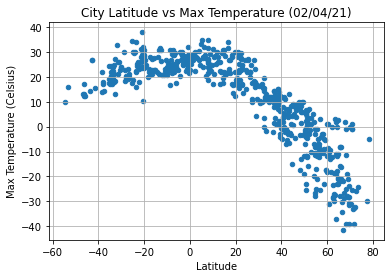

In [77]:
date= clean_city_data.Date.tolist()[0][0:8]
ax1 = clean_city_data.plot.scatter(x="Latitude", y="Max Temperature (Celsius)")
ax1.set_title(f"City Latitude vs Max Temperature ({date})")
ax1.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Max_Temperature_Scatter_Plot.png")
plt.show()

## Latitude vs. Humidity Plot

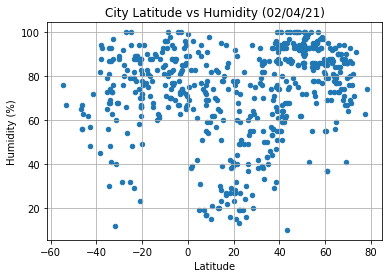

In [78]:
ax2 = clean_city_data.plot.scatter(x="Latitude", y="Humidity (%)")
ax2.set_title(f"City Latitude vs Humidity ({date})")
ax2.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Humidity_Scatter_Plot.png")
plt.show()

## Latitude vs. Cloudiness Plot

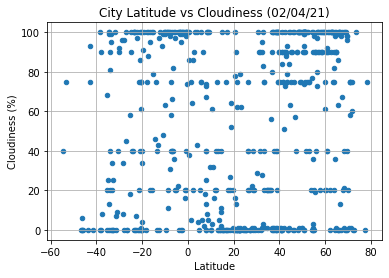

In [79]:
ax3 = clean_city_data.plot.scatter(x="Latitude", y="Cloudiness (%)")
ax3.set_title(f"City Latitude vs Cloudiness ({date})")
ax3.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Cloudiness_Scatter_Plot.png")
plt.show()

## Latitude vs. Wind Speed Plot

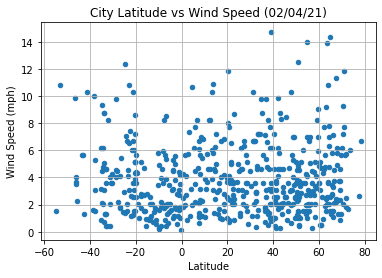

In [80]:
ax4 = clean_city_data.plot.scatter(x="Latitude", y="Wind Speed (mph)")
ax4.set_title(f"City Latitude vs Wind Speed ({date})")
ax4.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Wind_Speed_Scatter_Plot.png")
plt.show()

## Linear Regression

In [81]:
north_df = clean_city_data.loc[clean_city_data.Latitude>=0].reset_index()
n_lat = north_df.Latitude
north_df

,level_0,index,City,Latitude,Longitude,Max Temperature (Celsius),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,2,2,Chara,56.9064,118.2631,-25.50,78,100,0.25,RU,02/04/21 02:20
1,5,5,Shiyan,32.6475,110.7781,11.98,38,100,2.91,CN,02/04/21 02:20
2,7,7,Tura,25.5198,90.2201,27.04,30,0,1.15,IN,02/04/21 02:20
3,9,9,Zdvinsk,54.7021,78.6610,-11.40,94,1,4.14,RU,02/04/21 02:20
4,11,11,Albany,42.6001,-73.9662,-1.67,61,73,5.81,US,02/04/21 02:20
...,...,...,...,...,...,...,...,...,...,...,...
386,556,556,Zhangye,38.9342,100.4517,2.08,55,100,3.01,CN,02/04/21 02:23
387,557,557,St. George's,12.0564,-61.7485,26.00,83,40,8.23,GD,02/04/21 02:23
388,559,559,Arman',59.7000,150.1667,-18.22,81,61,9.06,RU,02/04/21 02:23
389,562,562,Panabá,21.2833,-88.2667,15.41,89,0,2.32,MX,02/04/21 02:23


In [82]:
south_df = clean_city_data.loc[clean_city_data.Latitude<0].reset_index()
s_lat=south_df.Latitude
south_df

,level_0,index,City,Latitude,Longitude,Max Temperature (Celsius),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,0,0,Namatanai,-3.6667,152.4333,27.31,81,99,3.14,PG,02/04/21 02:20
1,1,1,Bredasdorp,-34.5322,20.0403,22.00,68,13,2.06,ZA,02/04/21 02:16
2,3,3,Puerto Ayora,-0.7393,-90.3518,24.44,94,98,3.53,EC,02/04/21 02:20
3,4,4,New Norfolk,-42.7826,147.0587,26.67,48,93,1.34,AU,02/04/21 02:20
4,6,6,Punta Arenas,-53.1500,-70.9167,16.00,67,75,10.80,CL,02/04/21 02:20
...,...,...,...,...,...,...,...,...,...,...,...
168,537,537,Canguaretama,-6.3800,-35.1289,25.00,83,40,2.06,BR,02/04/21 02:23
169,539,539,De Aar,-30.6497,24.0123,23.00,68,40,3.60,ZA,02/04/21 02:18
170,558,558,Guaratinga,-16.5667,-39.5667,23.00,88,20,1.54,BR,02/04/21 02:23
171,560,560,San Martín,-33.0810,-68.4681,18.00,63,0,1.29,AR,02/04/21 02:23


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7956861398203462


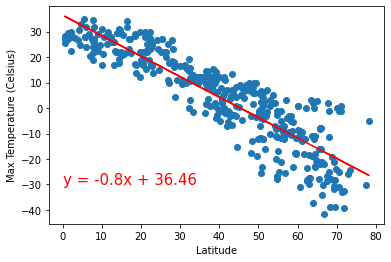

In [83]:
n_max_temp=north_df["Max Temperature (Celsius)"]
(slope_nt, intercept_nt, rvalue_nt, pvalue_nt, stderr_nt) = linregress(n_lat, n_max_temp)
regress_values_nt = n_lat * slope_nt + intercept_nt
line_eq_nt = "y = " + str(round(slope_nt,2)) + "x + " + str(round(intercept_nt,2))
axnt=plt.scatter(n_lat,n_max_temp)
plt.plot(n_lat,regress_values_nt,"r-")
plt.annotate(line_eq_nt,(0,-30),fontsize=15,color="red")
plt.ylabel("Max Temperature (Celsius)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_nt**2}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.24103859548150225


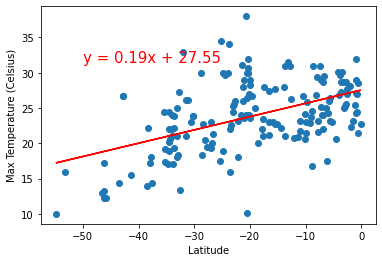

In [84]:
s_max_temp=south_df["Max Temperature (Celsius)"]
(slope_st, intercept_st, rvalue_st, pvalue_st, stderr_st) = linregress(s_lat, s_max_temp)
regress_values_st = s_lat * slope_st + intercept_st
line_eq_st = "y = " + str(round(slope_st,2)) + "x + " + str(round(intercept_st,2))
axst=plt.scatter(s_lat,s_max_temp)
plt.plot(s_lat,regress_values_st,"r-")
plt.annotate(line_eq_st,(-50,31.5),fontsize=15,color="red")
plt.ylabel("Max Temperature (Celsius)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_st**2}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.2087237144751016


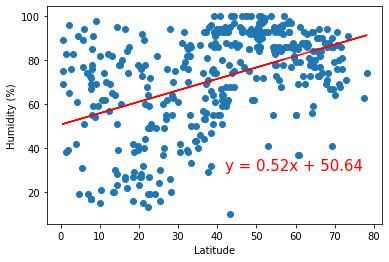

In [85]:
n_humidity=north_df["Humidity (%)"]
(slope_nh, intercept_nh, rvalue_nh, pvalue_nh, stderr_nh) = linregress(n_lat, n_humidity)
regress_values_nh = n_lat * slope_nh + intercept_nh
line_eq_nh = "y = " + str(round(slope_nh,2)) + "x + " + str(round(intercept_nh,2))
axnt=plt.scatter(n_lat,n_humidity)
plt.plot(n_lat,regress_values_nh,"r-")
plt.annotate(line_eq_nh,(42,30),fontsize=15,color="red")
plt.ylabel("Humidity (%)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_nh**2}")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.09394697943035539


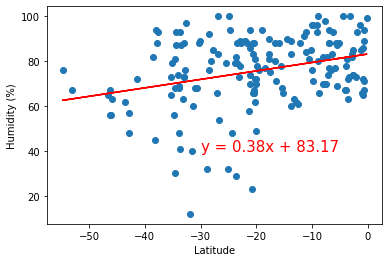

In [86]:
s_humidity=south_df["Humidity (%)"]
(slope_sh, intercept_sh, rvalue_sh, pvalue_sh, stderr_sh) = linregress(s_lat, s_humidity)
regress_values_sh = s_lat * slope_sh + intercept_sh
line_eq_sh = "y = " + str(round(slope_sh,2)) + "x + " + str(round(intercept_sh,2))
axnt=plt.scatter(s_lat,s_humidity)
plt.plot(s_lat,regress_values_sh,"r-")
plt.annotate(line_eq_sh,(-30,40),fontsize=15,color="red")
plt.ylabel("Humidity (%)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_sh**2}")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.09086005590252486


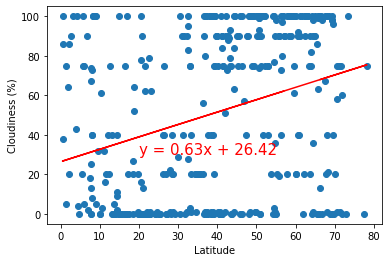

In [87]:
n_cloud=north_df["Cloudiness (%)"]
(slope_nc, intercept_nc, rvalue_nc, pvalue_nc, stderr_nc) = linregress(n_lat, n_cloud)
regress_values_nc = n_lat * slope_nc + intercept_nc
line_eq_nc = "y = " + str(round(slope_nc,2)) + "x + " + str(round(intercept_nc,2))
axnt=plt.scatter(n_lat,n_cloud)
plt.plot(n_lat,regress_values_nc,"r-")
plt.annotate(line_eq_nc,(20,30),fontsize=15,color="red")
plt.ylabel("Cloudiness (%)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_nc**2}")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.09986190394777136


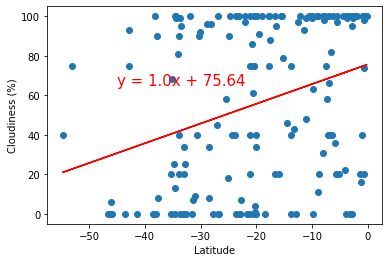

In [88]:
s_cloud=south_df["Cloudiness (%)"]
(slope_sc, intercept_sc, rvalue_sc, pvalue_sc, stderr_sc) = linregress(s_lat, s_cloud)
regress_values_sc = s_lat * slope_sc + intercept_sc
line_eq_sc = "y = " + str(round(slope_sc,2)) + "x + " + str(round(intercept_sc,2))
axnt=plt.scatter(s_lat,s_cloud)
plt.plot(s_lat,regress_values_sc,"r-")
plt.annotate(line_eq_sc,(-45,65),fontsize=15,color="red")
plt.ylabel("Cloudiness (%)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_sc**2}")
plt.show()


####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.00011256979422311958


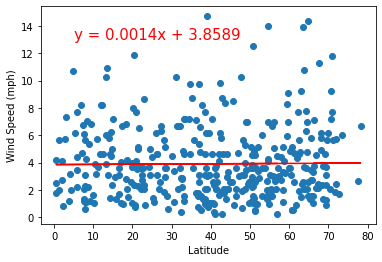

In [91]:
n_ws=north_df['Wind Speed (mph)']
(slope_ns, intercept_ns, rvalue_ns, pvalue_ns, stderr_ns) = linregress(n_lat, n_ws)
regress_values_ns = n_lat * slope_ns + intercept_ns
line_eq_ns = "y = " + str(round(slope_ns,4)) + "x + " + str(round(intercept_ns,4))
axnt=plt.scatter(n_lat,n_ws)
plt.plot(n_lat,regress_values_ns,"r-")
plt.annotate(line_eq_ns,(5,13),fontsize=15,color="red")
plt.ylabel("Wind Speed (mph)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_ns**2}")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.08545637259029754


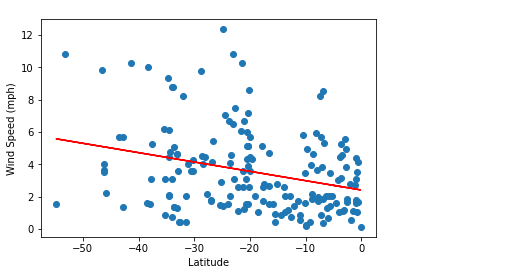

In [90]:
s_ws=south_df['Wind Speed (mph)']
(slope_ss, intercept_ss, rvalue_ss, pvalue_ss, stderr_ss) = linregress(s_lat, s_ws)
regress_values_ss = s_lat * slope_ss + intercept_ss
line_eq_ss = "y = " + str(round(slope_ss,2)) + "x + " + str(round(intercept_ss,2))
axnt=plt.scatter(s_lat,s_ws)
plt.plot(s_lat,regress_values_ss,"r-")
plt.annotate(line_eq_ss,(5,13),fontsize=15,color="red")
plt.ylabel("Wind Speed (mph)")
plt.xlabel('Latitude')
print(f"The r-squared is: {rvalue_ss**2}")
plt.show()